In [1]:
%matplotlib inline

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB :
  
  from google.colab import drive
  drive.mount('/content/drive')
  %cd /content/drive/MyDrive/Github

  repository= 'keyword_spotting'
  %cd {repository}
  %ls -a
  # CPU:
  #!pip install pydub torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

  # GPU:
  !pip install pydub torch==1.11.0+cu113 torchvision==0.12.0+cu113 torchaudio==0.11.0 -f https://download.pytorch.org/whl/torch_stable.html
    
working_dir=%pwd
if 'PROJET_ESSAI/notebooks' in working_dir :
    print('Wrong working directory')
    %cd ..
    working_dir=%pwd
    print('New directory :',working_dir)

if 'storage' not in locals():   
    storage=dict()


Wrong working directory
/Users/carlos/Documents/LeTaffe/PROJET_ESSAI
New directory : /Users/carlos/Documents/LeTaffe/PROJET_ESSAI


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio,torchvision
import matplotlib.pyplot as plt
import IPython.display as ipd
from tqdm import tqdm
import metrics.metrics as metrics
from dataset.subsetSC import SubsetSC
from models.mel_model import mel_model
from models.M5 import M5
from models.spectrogram_model import spectrogram_model
from helper.utilsFunc import *

working_dir=%pwd
if 'PROJET_ESSAI/notebooks' in working_dir :
    print('Wrong working directory')
    %cd ..
    working_dir=%pwd
    print('New directory :',working_dir)

if 'storage' not in locals():   
    storage=dict()

In [3]:
ls MFCC

MFCC.pt


In [4]:
storage['device'] = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using',storage['device'])

PATH='./M5/M5.pt'
model_type='M5'

Using cpu


## Downloading and setting up the dataset

In [5]:
with timeThat('training & test sets'):
    root='/content/sample_data' if IN_COLAB else './'
    if 'test_set' not in locals():
        test_set = SubsetSC("testing",root)
storage['waveform'], storage['sample_rate'], label, speaker_id, utterance_number = test_set[0]

batch_size = 100

if storage['device'] == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False
    
storage['test_loader']  = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=test_set.collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

training & test sets finished in  0:00:10.625122


## Let's visualize the data !

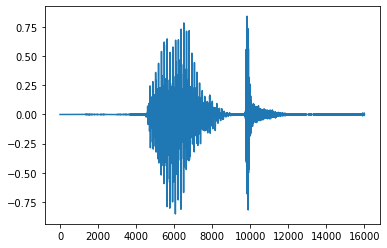

In [6]:
plt.plot(storage['waveform'].t().numpy())

In [7]:
n_mels=50
fe=16000
win_length=int(30e-3 *fe)
hop_length=int(10e-3 *fe)
n_fft=win_length 
spec_size=(fe -win_length)/hop_length +1
#print('size of tensor should be ',spec_size)

### transform : Resample|Spectrogram | MFCC

Shape of waveform: torch.Size([1, 8000])


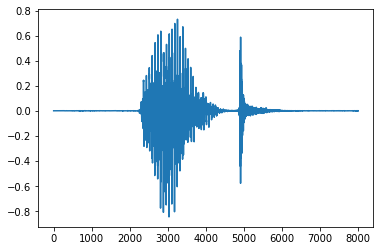

In [15]:
if model_type == 'MFCC' :
    MFCC_transform = torchaudio.transforms.MFCC(melkwargs={
        "n_fft": n_fft,
        "n_mels": n_mels,
        "hop_length": hop_length,
        "mel_scale": "htk",
    })
    data=MFCC_transform(storage['waveform'])
    waveform_size=data.shape
    
    print("Shape of Mel's spectrogram: {}".format(data.size()))
    plt.figure()
    p = plt.imshow(data.log2()[0].detach().numpy())
    
elif model_type == 'SPEC' :
    spectrogram_transform = torchaudio.transforms.Spectrogram(n_fft=n_fft,win_length=win_length,hop_length=hop_length)
    data=spectrogram_transform(storage['waveform'])
    waveform_size=data.shape
    
    print("Shape of spectrogram: {}".format(data.size()))
    plt.figure()
    plt.imshow(data.log2()[0].numpy())
    
elif model_type == 'M5':
    new_sample_rate=8000
    M5_transform = torchaudio.transforms.Resample(orig_freq=storage['sample_rate'], new_freq=new_sample_rate)
    data =M5_transform(storage['waveform'])
    
    print("Shape of waveform: {}".format(data.size()))
    plt.figure()
    plt.plot(data.t().numpy())



In [9]:
if model_type == 'MFCC' :
    storage['model'] = mel_model(input_shape=waveform_size, n_output=len(test_set.labels))
elif model_type == 'SPEC' :
    storage['model'] = spectrogram_model(input_shape=waveform_size, n_output=len(test_set.labels)) 
elif model_type == 'M5':
    storage['model'] = M5( n_output=len(test_set.labels)) 
            
            
storage['model'].to(storage['device'])
#print(storage['model'])
print("Number of parameters: %s" % storage['model'].count_parameters())
storage['model'].load_state_dict(torch.load(  PATH, map_location=storage['device']) )



Number of parameters: 26915


<All keys matched successfully>

## Visualisation des poids

showing weights


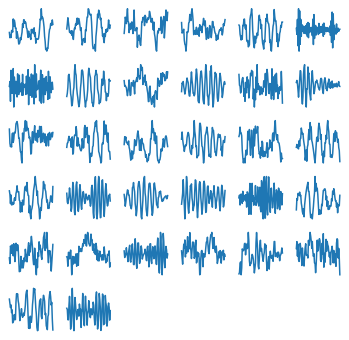

In [11]:
#TODO rendre ça plus propre
print('showing weights')
if model_type == 'SPEC' :
    FirstLayerWeights=storage['model'].conv1.weight.detach().cpu().numpy()
    plot_kernels2D(FirstLayerWeights)
elif model_type == 'MFCC' :
    FirstLayerWeights = storage['model'].conv1.weight.detach().cpu().numpy()
    plot_kernels2D(FirstLayerWeights)
elif model_type=='M5' :
    FirstLayerWeights=storage['model'].conv1.weight.detach().cpu().numpy()
    plot_kernels1D(FirstLayerWeights)


## Feature maps

showing feature maps


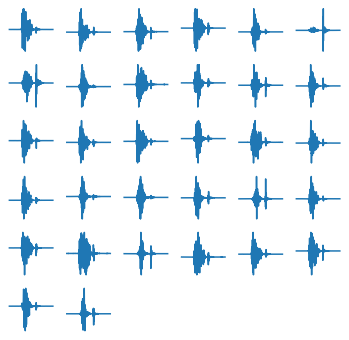

In [12]:
print('showing feature maps')
if model_type== 'MFCC' :
    featureMap =  storage['model'].conv1 (data) [:,None].detach()
    plot_kernels2D(featureMap)
elif model_type == 'SPEC' :
    featureMap = storage['model'].conv1 (data) [:,None].detach()
    plot_kernels2D(featureMap)
elif model_type == 'M5' :
    featureMap= storage['model'].conv1 (data) [:,None].detach()
    plot_kernels1D(featureMap)



In [17]:
from torch.utils.tensorboard import SummaryWriter
from helper.utilsFunc import *
#wr=SummaryWriter('runs/test2')